
# <font color='red'><i> Font Recognition by <b>16BCE103 & 16BCE094</b> </i> </font>

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import slidingwindow as sw
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses

C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1ty

### <font color='blue'><i> Visualization of sliding window </i> </font>

Dimensions before transformation :  2122 256
Dimensions after transformation :  2122 256
(256, 2122)


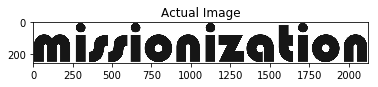

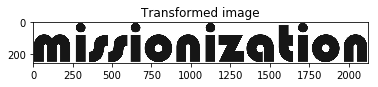

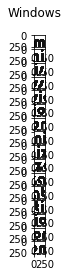

In [2]:
img = cv2.imread('../syn_generate/plain/bauhas_3.jpg', cv2.IMREAD_GRAYSCALE)
(h, w) = np.shape(img)

print("Dimensions before transformation : ", w, h)

if h < 256:
    ratio = 256 / h
    h = 256
    w = int(w * ratio)
else:
    ratio = h / 256
    h = 256
    w = int(w / ratio)

new_img = cv2.resize(img, (w, h))
windows = sw.generate(new_img, sw.DimOrder.HeightWidthChannel, 256, 0.5)

print("Dimensions after transformation : ", w, h)

print(np.shape(img))
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title('Actual Image')
plt.show()

plt.imshow(new_img, cmap=plt.get_cmap('gray'))
plt.title('Transformed image')
plt.show()

fig, axs = plt.subplots(len(windows))
fig.suptitle('Windows')
for i in range(0, len(windows)):
    axs[i].imshow(new_img[windows[i].indices()], cmap=plt.get_cmap('gray'))

plt.show()

In [3]:
# Globals
batch_size = 8
epoch = 10

In [4]:
# Creating data generators feeding 8 images at a time
def train_generator(batch_number_train, train_x, train_y):
    start_index = (batch_number_train-1)*batch_size
    end_index = batch_number_train*batch_size-1
    x, y = [], []
    for i in range(start_index, end_index + 1):
        img = cv2.imread(train_x[i], cv2.IMREAD_GRAYSCALE)
        (h, w) = np.shape(img)
        if h < 256:
            ratio = 256 / h
            h = 256
            w = int(w * ratio)
        else:
            ratio = h / 256
            h = 256
            w = int(w / ratio)
        new_img = cv2.resize(img, (w, h))
        windows = sw.generate(new_img, sw.DimOrder.HeightWidthChannel, 256, 0.5)
        for j in range(0, len(windows)):
            x.append(new_img[windows[j].indices()])
            y.append(train_y[i])
    x = np.array(x, dtype='float32')
    x /= 255
    (s,h,w) = np.shape(x)
    x = np.reshape(x, (s, h, w, 1))
    y = np.array(encoder.transform(y).toarray())
    return x, y

In [5]:
# Evalutating all the metrics using testing set
def validate(model, x, y):
    y_true, y_pred = [], []
    for i in range(0, len(x)):
        tx = []
        img = cv2.imread(x[i], cv2.IMREAD_GRAYSCALE)
        (h, w) = np.shape(img)
        if h < 256:
            ratio = 256 / h
            h = 256
            w = int(w * ratio)
        else:
            ratio = h / 256
            h = 256
            w = int(w / ratio)
        new_img = cv2.resize(img, (w, h))
        windows = sw.generate(new_img, sw.DimOrder.HeightWidthChannel, 256, 0.5)
        for j in range(0, len(windows)):
            tx.append(new_img[windows[j].indices()])
        tx = np.array(tx, dtype='float32')
        tx /= 255
        (s, h, w) = np.shape(tx)
        tx = np.reshape(tx, (s, h, w, 1))
        ty = model.predict(tx)
        final_sf = np.zeros(dtype='float32', shape=(10))
        for ti in range(0, len(ty)):
            for tj in range(0, 10):
                final_sf[tj] += ty[ti][tj]
        final_sf /= len(ty)
        final_sf = final_sf.reshape((-1, 10))
        y_pred.append(encoder.inverse_transform(final_sf)[0])
        y_true.append(y[i])
#     print("CONFUSION MATRIX")
#     print(confusion_matrix(y_true, y_pred))
    print("ACCURACY", accuracy_score(y_true, y_pred))

In [6]:
# Loading image destinations with their labels
path = '../syn_generate/plain/'
files = [f for f in os.listdir(path)]
x, y = [], []
for i in range(0, len(files)):
    file_name = os.path.splitext(os.path.basename(files[i]))[0]
    y.append(file_name.split('_')[0])
    x.append(os.path.join(path, files[i]))
y = np.reshape(y, (-1, 1))

In [7]:
# Fit the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(y)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [8]:
# Split into train and test
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.33, random_state=44)
del x, y

In [9]:
# Create the model
model = Sequential()
model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', data_format='channels_last'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', data_format='channels_last'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', data_format='channels_last'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', data_format='channels_last'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
__________

### <font color='blue'><i> Training </i> </font>

In [10]:
# Train the model
for epoch_no in range(0, 10):
    for batch in range(1, len(train_x)//batch_size):
        if batch%10==0:
            print("Epoch : ", epoch_no, " Batch : ", batch)
        x, y = train_generator(batch, train_x, train_y)
        model.fit(x, y, verbose=0)
    validate(model, test_x, test_y)

Epoch :  0  Batch :  10
Epoch :  0  Batch :  20
Epoch :  0  Batch :  30
Epoch :  0  Batch :  40
Epoch :  0  Batch :  50
Epoch :  0  Batch :  60
Epoch :  0  Batch :  70
Epoch :  0  Batch :  80
ACCURACY 0.693939393939394
Epoch :  1  Batch :  10
Epoch :  1  Batch :  20
Epoch :  1  Batch :  30
Epoch :  1  Batch :  40
Epoch :  1  Batch :  50
Epoch :  1  Batch :  60
Epoch :  1  Batch :  70
Epoch :  1  Batch :  80
ACCURACY 0.8212121212121212
Epoch :  2  Batch :  10
Epoch :  2  Batch :  20
Epoch :  2  Batch :  30
Epoch :  2  Batch :  40
Epoch :  2  Batch :  50
Epoch :  2  Batch :  60
Epoch :  2  Batch :  70
Epoch :  2  Batch :  80
ACCURACY 0.9545454545454546
Epoch :  3  Batch :  10
Epoch :  3  Batch :  20
Epoch :  3  Batch :  30
Epoch :  3  Batch :  40
Epoch :  3  Batch :  50
Epoch :  3  Batch :  60
Epoch :  3  Batch :  70
Epoch :  3  Batch :  80
ACCURACY 0.9787878787878788
Epoch :  4  Batch :  10
Epoch :  4  Batch :  20
Epoch :  4  Batch :  30
Epoch :  4  Batch :  40
Epoch :  4  Batch :  50
E

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-3b6d0d1feecd>", line 7, in <module>
    model.fit(x, y, verbose=0)
  File "C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1639, in fit
    validation_steps=validation_steps)
  File "C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training_arrays.py", line 215, in fit_loop
    outs = f(ins_batch)
  File "C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\backend.py", line 2986, in __call__
    run_metadata=self.run_metadata)
  File "C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\client\session.py", line 1439, in __call__
    run_metadata_ptr)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda\envs\tf\

KeyboardInterrupt: 

### <font color='blue'><i> Evaluation of the model </i> </font>

In [ ]:
# Calculate the confusion matrix
validate(model, test_x, test_y)